##### Copyright 2020 The TensorFlow Authors.

## Setup

Import necessary modules and dependencies.


In [79]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


import seaborn as sns
import librosa.display

# Set the seed value for experiment reproducibility.
#seed = 42
#tf.random.set_seed(seed)
#np.random.seed(seed)



In [80]:
import tensorflow_io as tfio
import soundfile
import statistics
import librosa as lb

read the patient's details from the .csv file

In [81]:
patient_data=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


plot each disease with the number of recordings in the data set

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

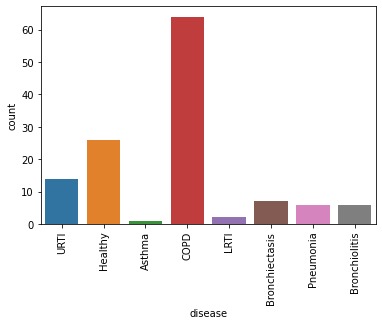

In [82]:
sns.countplot(patient_data.disease)
plt.xticks(rotation=90)

get breath times and periods from files

In [83]:
df=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


get the dataset path and file names of each racoding

In [84]:
path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
DATASET_PATH = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['168_1b1_Al_sc_Meditron',
 '172_1b4_Ar_mc_AKGC417L',
 '130_3p2_Pr_mc_AKGC417L',
 '177_2b4_Pl_mc_AKGC417L',
 '130_2p5_Pl_mc_AKGC417L']

create folder to put processed audio files

In [85]:
#save_path='processed_audio_files/' + filename
folder_path = 'processed_audio_files'
if not os.path.exists(folder_path):
    os.makedirs('processed_audio_files')

get the file name spilt by the '_' and put into a array

In [86]:
def getFilenameInfo(file):
    return file.split('_')

to process all files in the data set 24bit -> 16 bit pcm

add the disease label on the front of each racording

In [87]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.036,2.436,0,0,168,sc,168_1b1_Al_sc_Meditron
1,2.436,5.250,0,0,168,sc,168_1b1_Al_sc_Meditron
2,5.250,8.422,0,0,168,sc,168_1b1_Al_sc_Meditron
3,8.422,11.222,0,0,168,sc,168_1b1_Al_sc_Meditron
4,11.222,13.807,0,0,168,sc,168_1b1_Al_sc_Meditron


In [88]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [89]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 2
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [90]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

data=pd.merge(files_df,patient_data,on='pid')
data.head()
if not os.path.exists('csv_data'):
    os.makedirs('csv_data')
    data.to_csv('csv_data/data.csv',index=False)

function to extract breath cycle from each recording according to the start and end time

In [91]:


def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]



plot breath duration(seconds) with Paitiant ID

<AxesSubplot:ylabel='pid'>

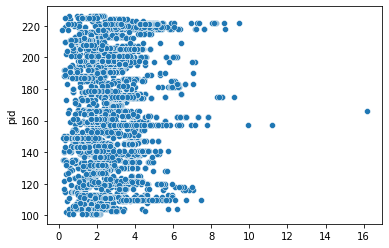

In [92]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

getaverage breath cycle

In [93]:
breath_length = data.end-data.start
average_length = statistics.mean(breath_length)
print(average_length)

2.700509085242099


In [94]:
#type(breath_length)
total_no_of_breaths = breath_length.count()
for i in range (int(average_length) , 16):
    count_less_than_i = 0
    for j in range (total_no_of_breaths):
        if (breath_length[j]<i):
            count_less_than_i = count_less_than_i+1
    percentage = count_less_than_i/total_no_of_breaths * 100
    print("duration " ,i , "percentage of samples below that" , percentage)


duration  2 percentage of samples below that 27.1672948680777
duration  3 percentage of samples below that 64.77239779646274
duration  4 percentage of samples below that 88.50391417802261
duration  5 percentage of samples below that 96.60771238040012
duration  6 percentage of samples below that 98.27486227892143
duration  7 percentage of samples below that 99.39112786314874
duration  8 percentage of samples below that 99.78254566541025
duration  9 percentage of samples below that 99.92751522180342
duration  10 percentage of samples below that 99.97100608872137
duration  11 percentage of samples below that 99.97100608872137
duration  12 percentage of samples below that 99.98550304436068
duration  13 percentage of samples below that 99.98550304436068
duration  14 percentage of samples below that 99.98550304436068
duration  15 percentage of samples below that 99.98550304436068


98% of breathing cycles are below 6s

In [95]:
new_samplerate = 16000
folder_path = 'processed_audio_files'
c = 0

for i in files:
    filename = i
    data, samplerate = soundfile.read(DATASET_PATH+filename+'.wav')
   # print(samplerate)
    file_name_data = getFilenameInfo(filename)
    for pid,disease in patient_data.iterrows():
        if disease[0] == int(file_name_data[0]):
            soundfile.write(folder_path + '/' + disease[1] + '_' + filename +'.wav', data, new_samplerate, subtype='PCM_16')
  


read new filenames

In [96]:
audio_data_dir = "processed_audio_files/*.wav"

filenames = tf.io.gfile.glob(audio_data_dir)

#filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print (filenames[:5])

Number of total examples: 920
['processed_audio_files/COPD_147_2b3_Al_mc_AKGC417L.wav', 'processed_audio_files/COPD_200_2p2_Pl_mc_AKGC417L.wav', 'processed_audio_files/COPD_200_2p4_Lr_mc_AKGC417L.wav', 'processed_audio_files/COPD_186_3b3_Pr_mc_AKGC417L.wav', 'processed_audio_files/COPD_181_1b1_Tc_mc_LittC2SE.wav']


split the data set into 3 parts - > train / test / validate

In [97]:
train_files = filenames[:736]
val_files = filenames[736: 828 ]
test_files = filenames[-92:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 736
Validation set size 92
Test set size 92


labels of the data set with patient conditions

In [98]:
disease_labels = np.array(["asthma","COPD","Bronchiectasis","Pneumonia","URTI","healthy"])

function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [99]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [100]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-1]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [101]:
file_name_data = getFilenameInfo('160_1b3_Al_mc_AKGC417L')
#print(int(file_name_data[0]))

for pid,disease in patient_data.iterrows():
    #print(type(disease[0]))
    if disease[0] == int(file_name_data[0]):
        print (disease[1])

COPD


In [102]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print (label)
  parts = tf.strings.split(
      input=label,
      sep='_')

  label = parts[0]   # contains a tensor with pids
  
  audio_binary = tf.io.read_file(file_path)

  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [103]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Tensor("strided_slice:0", shape=(), dtype=string)


Let's plot a few audio waveforms:

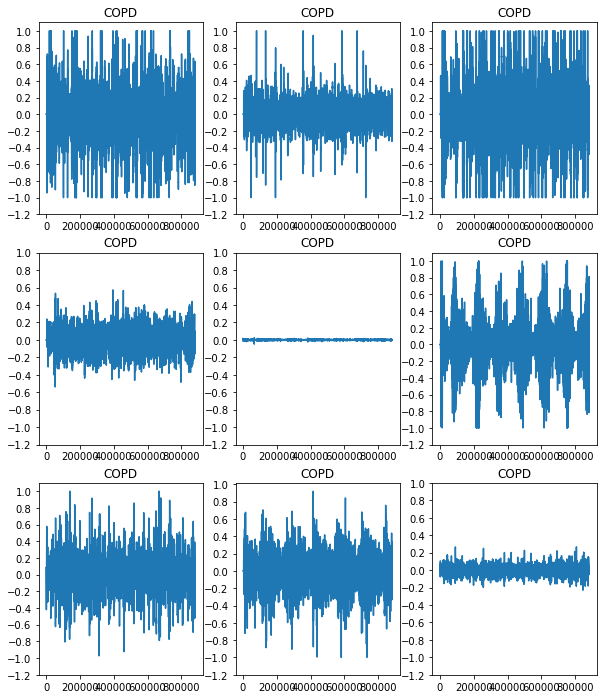

In [104]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## transform to spectrograms -  > STFT


In [105]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [106]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: COPD
Waveform shape: (882000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [107]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

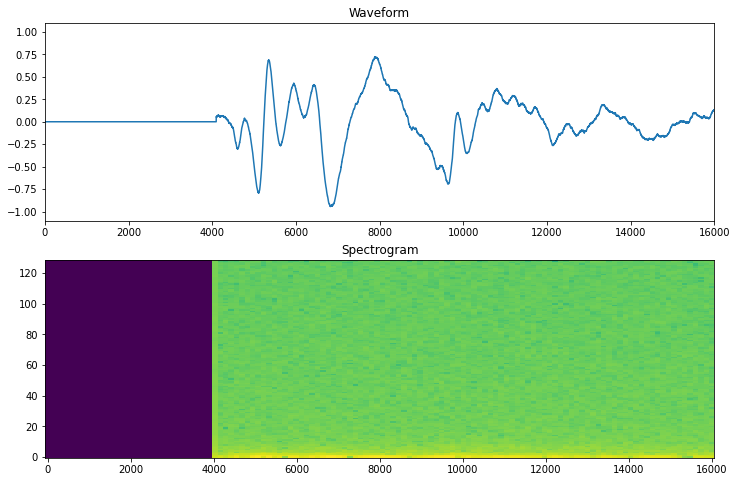

In [108]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [109]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == disease_labels)
  
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [110]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)


Examine the spectrograms for different examples of the dataset:

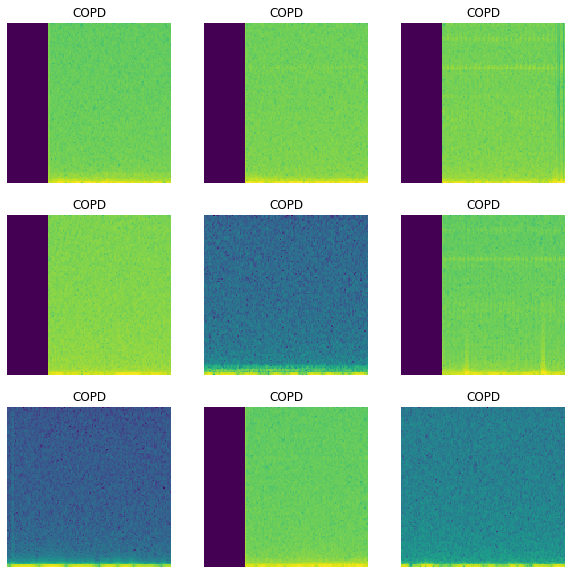

In [111]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(disease_labels[label_id.numpy()])
  
  ax.axis('off')
  
plt.show()

## MFCC Spectrogram

[Text(0.5, 1.0, 'MFCC')]

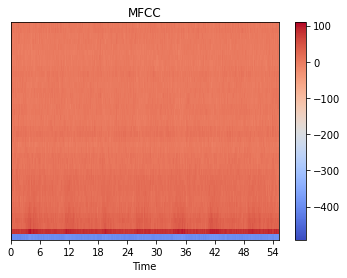

In [112]:


sample_file = 'processed_audio_files/COPD_172_1b3_Pl_mc_AKGC417L.wav'

import librosa.display
#file=path + Xtrain.iloc[193].filename 
sound,sample_rate=librosa.load(sample_file)
mfccs = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')



## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [113]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [114]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)


Batch the training and validation sets for model training:

In [115]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [116]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [117]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(disease_labels)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [118]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [119]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
12/12 [==============================] - 7s 507ms/step - loss: 0.8488 - accuracy: 0.7962 - val_loss: 0.7219 - val_accuracy: 0.8152
Epoch 2/10
12/12 [==============================] - 1s 115ms/step - loss: 0.5549 - accuracy: 0.8655 - val_loss: 0.6410 - val_accuracy: 0.8152
Epoch 3/10
12/12 [==============================] - 1s 82ms/step - loss: 0.5009 - accuracy: 0.8655 - val_loss: 0.5599 - val_accuracy: 0.8152
Epoch 4/10
12/12 [==============================] - 1s 82ms/step - loss: 0.4832 - accuracy: 0.8641 - val_loss: 0.5343 - val_accuracy: 0.8152
Epoch 5/10
12/12 [==============================] - 1s 83ms/step - loss: 0.4551 - accuracy: 0.8601 - val_loss: 0.5182 - val_accuracy: 0.8152
Epoch 6/10
12/12 [==============================] - 1s 82ms/step - loss: 0.4220 - accuracy: 0.8628 - val_loss: 0.4627 - val_accuracy: 0.8152
Epoch 7/10
12/12 [==============================] - 1s 88ms/step - loss: 0.4312 - accuracy: 0.8519 - val_loss: 0.4630 - val_accuracy: 0.8152
Epoch 8/10


Let's plot the training and validation loss curves to check how your model has improved during training:

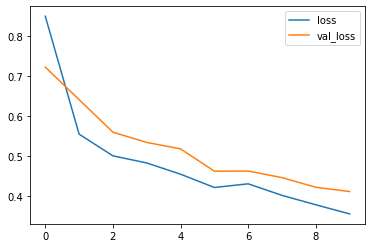

In [120]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [121]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [122]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


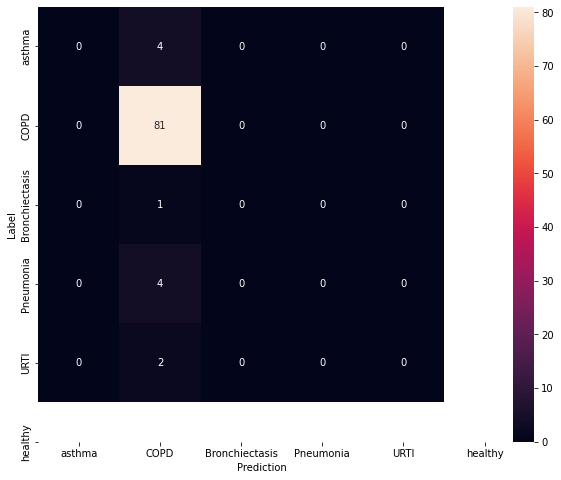

In [123]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=disease_labels,
            yticklabels=disease_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

Tensor("strided_slice:0", shape=(), dtype=string)


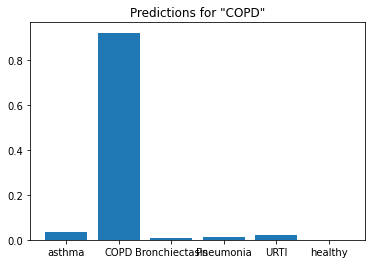

In [124]:
sample_file = 'processed_audio_files/COPD_172_1b3_Pl_mc_AKGC417L.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(disease_labels, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{disease_labels[label[0]]}"')
  plt.show()

As the output suggests, your model should have recognized the audio command as "no".

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle's TensorFlow speech recognition challenge</a>.
- The 
<a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - Audio recognition using transfer learning codelab</a> teaches how to build your own interactive web app for audio classification.
- <a href="https://arxiv.org/abs/1709.04396" class="external">A tutorial on deep learning for music information retrieval</a> (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the <a href="https://librosa.org/" class="external">librosa</a> library—a Python package for music and audio analysis.